<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/GenerativeModelDemo/blob/main/PresentationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
import torch
from diffusers import StableDiffusionAdapterPipeline, T2IAdapter
import os
import kagglehub
import shutil
import pandas as pd
import numpy as np
from PIL import Image
from datasets import Dataset

In [3]:
!pwd

/content


In [4]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("adityajn105/flickr8k")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


In [5]:
df = pd.read_csv("./dataset/captions.txt")
df.rename(columns={'image':"filename"}, inplace=True)
df.loc[:1000]

,filename,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
996,124195430_d14028660f.jpg,A brown horse stands near a black horse that i...
997,124195430_d14028660f.jpg,A large brown horse stands over a small black ...
998,124195430_d14028660f.jpg,An adult horse approaching a foal on a sandy p...
999,124195430_d14028660f.jpg,A thin brown horse standing and a small black ...


In [6]:
def load_image(example):
    image_path = os.path.join("./dataset/Images", example["filename"])
    image = Image.open(image_path).convert("RGB")
    image = image.resize((64, 64))
    example['images'] = image
    conditioning_image = image.resize((8, 8))
    conditioning_image = conditioning_image.resize((64, 64), resample=Image.Resampling.NEAREST)
    example['conditioning_images'] = conditioning_image

    return example

dataset = Dataset.from_pandas(df.loc[:50])
dataset = dataset.map(load_image)
dataset[0]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

{'filename': '1000268201_693b08cb0e.jpg',
 'caption': 'A child in a pink dress is climbing up a set of stairs in an entry way .',
 'images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x64>,
 'conditioning_images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x64>}

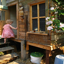

In [7]:
dataset[0]['images']

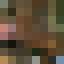

In [8]:
dataset[0]["conditioning_images"]

In [9]:
adapter = T2IAdapter.from_pretrained("TencentARC/t2iadapter_color_sd14v1", torch_dtype=torch.float16)
pipe = StableDiffusionAdapterPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    adapter=adapter,
    torch_dtype=torch.float16,
)
pipe.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
An error occurred while trying to fetch TencentARC/t2iadapter_color_sd14v1: TencentARC/t2iadapter_color_sd14v1 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionAdapterPipeline {
  "_class_name": "StableDiffusionAdapterPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "adapter": [
    "diffusers",
    "T2IAdapter"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [10]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms

# DataLoader function
def collate_fn(batch):
    images = [example["images"] for example in batch]
    conditions = [example["conditioning_images"] for example in batch]
    texts = [example["caption"] for example in batch]
    return images, conditions, texts

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Define optimizer
optimizer = torch.optim.Adam(pipe.adapter.parameters(), lr=1e-4)

# Convert Image to pytorch tensor and move to GPU
transform = transforms.Compose([
    transforms.PILToTensor()
])

In [11]:
images, conditioning_images, texts = next(iter(dataloader))
images = [transform(img) for img in images]
images = torch.stack(images)
images.shape

torch.Size([4, 3, 64, 64])

In [17]:
# Training loop
for epoch in range(10):  # Number of epochs
    for images, conditioning_images, texts in dataloader:
        optimizer.zero_grad()

        # Move to GPU
        images = [transform(img).type(torch.float16) for img in images]
        images = torch.stack(images)
        images = images.to("cuda")

        conditioning_images = [transform(cond).type(torch.float16) for cond in conditioning_images]
        conditioning_images = torch.stack(conditioning_images)
        conditioning_images = conditioning_images.to("cuda")

        # Generate latents
        latents = pipe.vae.encode(images).latent_dist.sample()
        latents = latents * 0.18215  # Scale latents

        # Generate conditioning latents
        cond_latents = pipe.vae.encode(conditioning_images).latent_dist.sample()
        cond_latents = cond_latents * 0.18215

        # Text
        input_ids = pipe.tokenizer(
            texts, padding=True, truncation=True, return_tensors="pt"
        ).input_ids.to("cuda")
        encoder_hidden_states = pipe.text_encoder(input_ids).last_hidden_state.to("cuda")

        # Compute loss (MSE loss)
        noise = torch.randn_like(latents)
        noisy_latents = latents + noise

        timestep = torch.randint(1, 1000, (1,), device=pipe.device).type(torch.float16)

        predicted_noise = pipe.unet(noisy_latents, timestep, encoder_hidden_states, cond_latents).sample
        loss = F.mse_loss(predicted_noise, noise)

        # Backpropagation
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} Loss: {loss.item()}")

Epoch 0 Loss: 0.273681640625
Epoch 1 Loss: 0.41796875
Epoch 2 Loss: 0.431396484375
Epoch 3 Loss: 0.276123046875
Epoch 4 Loss: 0.1807861328125
Epoch 5 Loss: 0.1917724609375
Epoch 6 Loss: 0.2802734375
Epoch 7 Loss: 0.42626953125
Epoch 8 Loss: 0.1422119140625
Epoch 9 Loss: 0.2218017578125


In [ ]:
# generator = torch.manual_seed(0)

# out_image = pipe(
#     "At night, glowing cubes in front of the beach",
#     image=...,
#     generator=generator,
# ).images[0]